In [ ]:
#VISUALIZACION DE INTERPRETACION
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from groundedPL.logic_tester import LogicTester
from itertools import product, combinations
import random
lt = LogicTester()

NUM_FILAS = 5
NUM_COLUMNAS = 5

def visualizar(I):
        # Inicializo el plano que contiene la figura
        fig, axes = plt.subplots()
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
        ax = plt.gca()
        ax.set_facecolor('lightslategrey')

        step = 1/NUM_FILAS
        tangulos = []
        font_size = step * 100
        colors = dict()
        colors[1] = (0,0,1)
        colors[2] = (0,0.5,0)
        colors[3] = (1,0,0)
        colors[4] = (0,0,0.5)
        colors[5] = (0.5,0,0)
        colors[6] = (0,0.5,0.5)
        colors[7] = (0,0,0)
        colors[8] = (0.5,0.5,0.5)

        # Creo los cuadrados claros en el tablero
        for atomo in I:
            if I[atomo]:
                # DECODIFICAMOS EL ÁTOMO PARA VISUALIZACIÓN
                predicado = lt.to_lp.obtener_predicado(atomo)
                if(len(lt.to_lp.obtener_argumentos(atomo)) > 2):
                    x, y, n = lt.to_lp.obtener_argumentos(atomo)
                    n = int(n)
                else:
                    x, y = lt.to_lp.obtener_argumentos(atomo)
                x = int(x)
                old_y = y
                y = NUM_COLUMNAS - int(y) - 1


                if predicado == 'ELECCION':
                    # tangulos.append(patches.Rectangle((step * x, step * y), step, step, facecolor='lightslategrey'))
                    plt.text(x * step + step * 3 / 4,
                             y * step + step * 3 / 4,
                             f'E',
                             fontsize=font_size/2,
                             color='lawngreen')
                elif predicado == 'MINA':
                    # tangulos.append(patches.Rectangle((step * x, step * y), step, step, facecolor='lightslategrey'))
                    plt.text(x * step + step / 4,
                             y * step + step / 4,
                             f'M',
                             fontsize=font_size/2,
                             color='red')
                elif predicado == 'NUM' and n > 0:
                    tangulos.append(patches.Rectangle((step * x, step * y), step, step, facecolor='white'))
                    plt.text(x * step + step / 2,
                             y * step + step / 2,
                             f'{n}',
                             fontsize=font_size,
                             color=colors[n])

        # Creo las líneas del tablero
        for j in range(8):
            locacion = j * step
            # Crea linea horizontal en el rectangulo
            tangulos.append(patches.Rectangle(*[(0, step + locacion), 1, 0.005],\
                    facecolor='black'))
            # Crea linea vertical en el rectangulo
            tangulos.append(patches.Rectangle(*[(step + locacion, 0), 0.005, 1],\
                    facecolor='black'))
        # Dibujo el tablero
        for t in tangulos:
            axes.add_patch(t)
        plt.show()

In [2]:
#CONVERTIR MODELO EN DICCIONARIO
def to_dict(literales: list[str]):
    I = dict()
    for literal in literales:
        if literal[0] == '-':
            I[literal[1:]] = False
        else:
            I[literal] = True
    return I

In [166]:
#GENERACION DE TABLERO Y REGLAS
casillas = [(x,y) for x in range(NUM_FILAS) for y in range(NUM_COLUMNAS)]
nums = range(9)

for x, y in product(range(NUM_FILAS), range(NUM_COLUMNAS)):
    formula = f'MINA({x},{y})'
    lt.to_lp.parse(formula)
    formula = f'ELECCION({x},{y})'
    lt.to_lp.parse(formula)
    for n in nums:
        formula = f'NUM({x},{y},{n})'
        lt.to_lp.parse(formula)


def vecinos(pos: tuple[int,int]):
    vecinos = [(x,y) for x in range(pos[0] - 1, pos[0] + 2) for y in range(pos[1] - 1, pos[1] + 2)]
    vecinos = [casilla for casilla in vecinos if casilla != pos and 0 <= casilla[0] < NUM_FILAS and 0 <= casilla[1] < NUM_COLUMNAS]
    return vecinos

def YtoriaForms(lista_forms):
    form = ''
    inicial = True
    if len(lista_forms) == 0:
        return None
    for f in lista_forms:
        if inicial:
            form = f
            inicial = False
        else:
            form = '(' + form + '∧' + f + ')'
    return form

def Ytoria(lista_forms):
    form = ''
    inicial = True
    if len(lista_forms) == 0:
        return None
    for f in lista_forms:
        if inicial:
            form = f
            inicial = False
        else:
            form = '(' + form + '&' + f + ')'
    return form

def Otoria(lista_forms):
    form = ''
    inicial = True
    for f in lista_forms:
        if inicial:
            form = f
            inicial = False
        else:
            form = '(' + form + '|' + f + ')'
    return form

def tapado(casilla):
    (x,y) = casilla
    nums_posibles = range(9)
    if (x == 0 or x == 4) and (y == 0 or y == 4):
        nums_posibles = range(4)
    elif (x == 0 or x == 4) or (y == 0 or y == 4):
        nums_posibles = range(6)
    return Ytoria([f'-NUM({casilla[0]},{casilla[1]},{n})' for n in nums_posibles])

def destapado(casilla):
    (x,y) = casilla
    nums_posibles = range(9)
    if (x == 0 or x == 4) and (y == 0 or y == 4):
        nums_posibles = range(4)
    elif (x == 0 or x == 4) or (y == 0 or y == 4):
        nums_posibles = range(6)
    return Otoria([f'NUM({casilla[0]},{casilla[1]},{n})' for n in nums_posibles])

def bicondicional(a, b):
    return f'(({a}->{b})&({b}->{a}))'

#regla 1: si hay un numero, no hay una mina
def regla_1():
    formulas = []
    for (x,y) in casillas:
        formula = f'(({destapado((x,y))}) -> -MINA({x},{y}) )'
        formulas.append(formula)
    return Ytoria(formulas)

#Regla 2: Una casilla contiene solo un numero
def regla_2():
    formulas = []
    for (x, y) in casillas:
        for n in nums:
            if n > len(vecinos((x,y))) or n not in nums_en_tablero:
                continue
            for m in nums:
                if m > n:
                    formulas.append(f'(NUM({x},{y},{n}) -> -NUM({x},{y},{m}))')
    return Ytoria(formulas)



#------------Reglas de elección de casilla----------

#Regla 3: Una casilla (x,y) es seleccionable si y solo si no contiene una mina y es tapada
def regla_3():
    forms = []
    for (x,y) in casillas:
        a = f'ELECCION({x},{y})'
        b = f'-MINA({x},{y}) & {tapado((x,y))}'
        formula = bicondicional(a,b)
        forms.append(formula)
    return Ytoria(forms)


#Regla 4:  Si una casilla destapada (x,y) contiene al numero n, y se tienen n vecinos marcados inseleccionables 
#(es decir, se dedujo que tienen una mina), el resto de vecinos tapados no son minas.

def regla_4():
    forms = []
    for (x, y) in casillas:
        vec = vecinos((x, y))
        for n in nums:
            if n >= len(vec) or n not in nums_en_tablero:
                continue
            if n == 0:
                forms_0 = []
                for v in vec:
                    formula = f'(NUM({x},{y},{n}) -> ({tapado(v)} -> ELECCION({v[0]},{v[1]})))'
                    forms_0.append(formula)
                ytoria = Ytoria(forms_0)
                forms.append(ytoria)
                continue

            combinaciones = combinations(vec, n)
            otoria_combinaciones = []
            for S in combinaciones:
                configuracion_minas = []
                elegibles = []
                for v in vec:
                    if v in S:
                        configuracion_minas.append(f'MINA({v[0]},{v[1]})')
                    else:
                        elegibles.append(v)
                        configuracion_minas.append(f'-MINA({v[0]},{v[1]})')
                ytoria_vecinos = Ytoria(configuracion_minas)
                formula = f'(NUM({x},{y},{n}) & ({ytoria_vecinos})) -> (({Ytoria([tapado(a) for a in elegibles])}) -> {Ytoria([f'ELECCION({b[0]},{b[1]})' for b in elegibles])})'
                otoria_combinaciones.append(formula)
            otoria = Otoria(otoria_combinaciones)
            forms.append(otoria)
    return Ytoria(forms)

minas = [(3,3)]
nums_en_tablero = set()

#Regla para definir un tablero parcial
def regla_tablero():
    literales = []
    tablero = []
    for _ in range(NUM_FILAS):
        fila = []
        for _ in range(NUM_COLUMNAS):
            fila.append(0)
        tablero.append(fila)

    for mina in minas:
        for vecino in vecinos(mina):
            if vecino not in minas:
                tablero[vecino[1]][vecino[0]] += 1

    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            if (x,y) in minas:
                tablero[y][x] = '*'
                for n in nums:
                    literales.append(f'-NUM({x},{y},{n})')
            else:
                chance = random.randint(0,9)
                num = tablero[y][x]
                if chance < 5 or (x,y) == (0,0):
                    literales.append(f'NUM({x},{y},{num})')
                    nums_en_tablero.add(num)
                else:
                    for n in nums:
                        literales.append(f'-NUM({x},{y},{n})')
                    tablero[y][x] = '-'
    
    for fila in tablero:
        for casilla in fila:
            print(f'{str(casilla)}', end=', ')
        print('\n')
    return Ytoria(literales)

def reglas_individual():
    r = []
    print('reglaTablero')
    r.append(lt.translation_to_prover(regla_tablero()))
    print('regla1')
    r.append(lt.translation_to_prover(regla_1()))
    print('regla2')
    r.append(lt.translation_to_prover(regla_2()))
    print('regla3')
    r.append(lt.translation_to_prover(regla_3()))
    print('regla4')
    r.append(lt.translation_to_prover(regla_4()))
    print('reglas listas.')
    return YtoriaForms(r)


reglaTablero
0, 0, -, -, 0, 

0, -, -, -, -, 

-, 0, 1, 1, 1, 

-, -, -, *, -, 

0, -, -, -, -, 

regla1


regla2
regla3
regla4
reglas listas.


  0%|          | 0/50005 [01:34<?, ?it/s]


La fórmula es satisfacible

El modelo decodificado es:

	['NUM(0, 0, 0)', 'NUM(0, 1, 0)', '-NUM(0, 2, 0)', '-NUM(0, 2, 1)', '-NUM(0, 2, 2)', '-NUM(0, 2, 3)', '-NUM(0, 2, 4)', '-NUM(0, 2, 5)', '-NUM(0, 2, 6)', '-NUM(0, 2, 7)', '-NUM(0, 2, 8)', '-NUM(0, 3, 0)', '-NUM(0, 3, 1)', '-NUM(0, 3, 2)', '-NUM(0, 3, 3)', '-NUM(0, 3, 4)', '-NUM(0, 3, 5)', '-NUM(0, 3, 6)', '-NUM(0, 3, 7)', '-NUM(0, 3, 8)', 'NUM(0, 4, 0)', 'NUM(1, 0, 0)', '-NUM(1, 1, 0)', '-NUM(1, 1, 1)', '-NUM(1, 1, 2)', '-NUM(1, 1, 3)', '-NUM(1, 1, 4)', '-NUM(1, 1, 5)', '-NUM(1, 1, 6)', '-NUM(1, 1, 7)', '-NUM(1, 1, 8)', 'NUM(1, 2, 0)', '-NUM(1, 3, 0)', '-NUM(1, 3, 1)', '-NUM(1, 3, 2)', '-NUM(1, 3, 3)', '-NUM(1, 3, 4)', '-NUM(1, 3, 5)', '-NUM(1, 3, 6)', '-NUM(1, 3, 7)', '-NUM(1, 3, 8)', '-NUM(1, 4, 0)', '-NUM(1, 4, 1)', '-NUM(1, 4, 2)', '-NUM(1, 4, 3)', '-NUM(1, 4, 4)', '-NUM(1, 4, 5)', '-NUM(1, 4, 6)', '-NUM(1, 4, 7)', '-NUM(1, 4, 8)', '-NUM(2, 0, 0)', '-NUM(2, 0, 1)', '-NUM(2, 0, 2)', '-NUM(2, 0, 3)', '-NUM(2, 0, 4)', '-NUM(2, 0, 

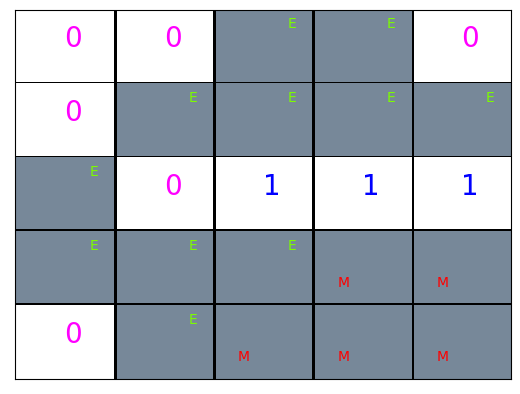

In [167]:
#SOLUCION DEL PROBLEMA
# formula_lp = lt.translation_to_prover(reglas())
formula_lp = reglas_individual()
res = lt.SATsolve(formula_lp)
modelo = []
if res == 'UNSAT':
    print('La fórmula es insatisfacible')
else:
    print('La fórmula es satisfacible')
    modelo = [lt.to_numeric.literal(x) for x in res]
    modelo = [x for x in modelo if lt.to_numeric.solo_atomo(x) in lt.tseitin.atomos] 
    # print(f'\nUn modelo es:\n\n\t{modelo}')
    decodificado = [lt.to_lp.modelo_lp.decodificar(x) for x in modelo]
    print(f'\nEl modelo decodificado es:\n\n\t{decodificado}')
    I = to_dict(modelo)
    visualizar(I)